<VSCode.Cell language="markdown">
# Hierarchical Clustering and Comparison with K-Means

This notebook demonstrates hierarchical (agglomerative) clustering from scratch using SciPy's linkage implementation, generates a dendrogram, and compares the hierarchical clustering results with a K-Means run (same dataset and number of clusters).

We will:

1. Recreate the same dataset used in `k_means_clustering.ipynb` for a fair comparison.
2. Compute hierarchical clustering (linkage matrix) and plot a dendrogram.
3. Cut the dendrogram to obtain `k` clusters and visualize them.
4. Run K-Means (same k, same random seed) and visualize.
5. Compute comparison metrics: Adjusted Rand Index (ARI), Adjusted Mutual Information (AMI), and silhouette score.

Notes:
- Visualizations use matplotlib and will show 2D scatter plots (for n>2 you'd apply PCA/TSNE before plotting).
- The dataset is generated with a fixed random seed to match `k_means_clustering.ipynb`'s example.

In [1]:

# Imports and helper functions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

sns.set(style='whitegrid')

# Simple plotting helper for clusters
def plot_clusters(X, labels, centroids=None, title=None):
    plt.figure(figsize=(7,5))
    scatter = plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=40, alpha=0.7)
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x', s=150, linewidths=3, label='Centroids')
        plt.legend()
    plt.title(title if title else '')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


/var/folders/1m/rwrjh2pn38v3y035yqrb59b40000gn/T/ipykernel_12469/2010722203.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=40, alpha=0.7)


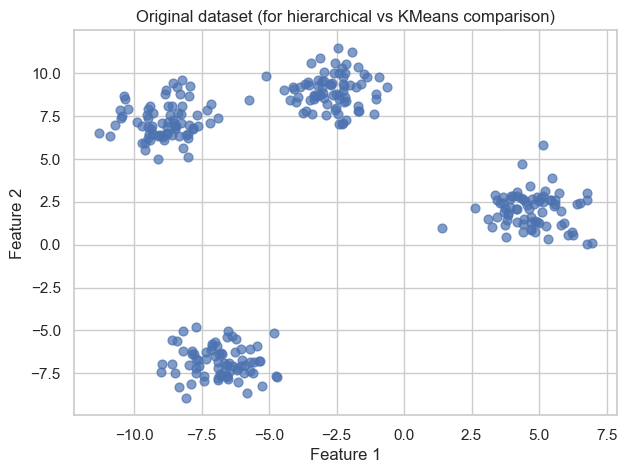

In [2]:

# 1) Create the same dataset as used in k_means_clustering.ipynb
np.random.seed(42)
X, true_labels = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# Plot the original data
plot_clusters(X, labels=None, title='Original dataset (for hierarchical vs KMeans comparison)')


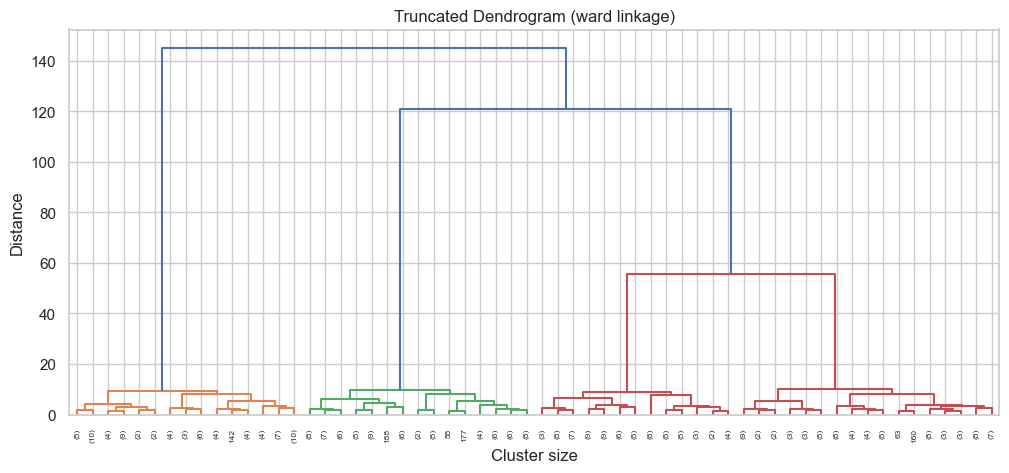

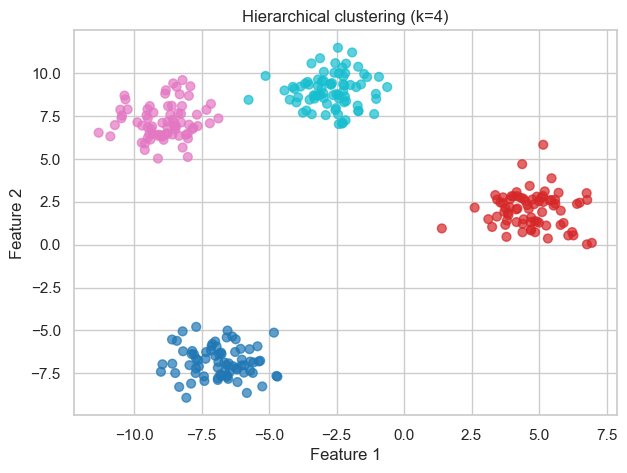

In [3]:

# 2) Hierarchical clustering: compute linkage and plot dendrogram
# We use 'ward' linkage as a common default for Euclidean distance.
Z = linkage(X, method='ward', metric='euclidean')

plt.figure(figsize=(12, 5))
# Plot full dendrogram can be large; show truncated version with last 60 merges for readability
ddata = dendrogram(Z, truncate_mode='lastp', p=60, show_leaf_counts=True, leaf_rotation=90.)
plt.title('Truncated Dendrogram (ward linkage)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# Cut dendrogram to obtain k clusters
k = 4
hier_labels = fcluster(Z, t=k, criterion='maxclust') - 1  # make labels 0..k-1

# Visualize hierarchical clustering result
plot_clusters(X, labels=hier_labels, title=f'Hierarchical clustering (k={k})')


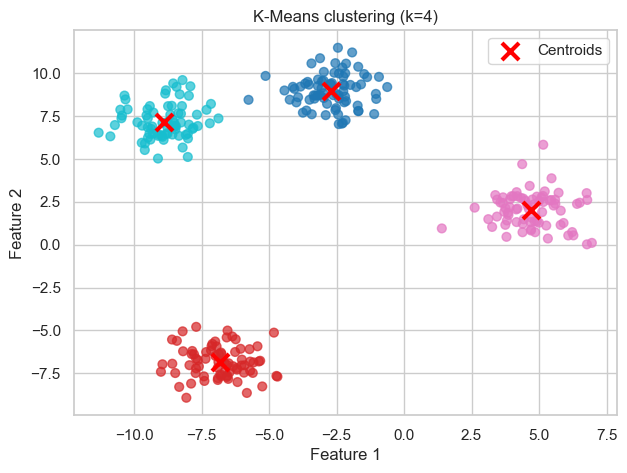

In [6]:

# 3) Run K-Means for comparison (use sklearn KMeans with same random_state for reproducibility)
sk_kmeans = SKLearnKMeans(n_clusters=k, random_state=42, n_init=10)
sk_labels = sk_kmeans.fit_predict(X)

# Visualize KMeans result
plot_clusters(X, labels=sk_labels, centroids=sk_kmeans.cluster_centers_, title=f'K-Means clustering (k={k})')


Comparison metrics (k=4):
Adjusted Rand Index (ARI): 1.0000
Adjusted Mutual Information (AMI): 1.0000
Silhouette score (Hierarchical): 0.7916
Silhouette score (KMeans): 0.7916


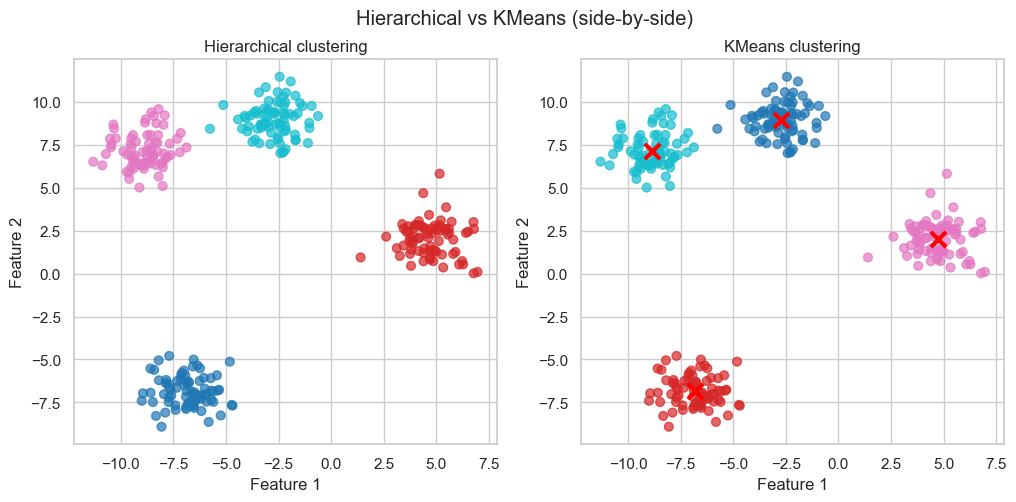

In [7]:

# 4) Compute comparison metrics
ari = adjusted_rand_score(hier_labels, sk_labels)
ami = adjusted_mutual_info_score(hier_labels, sk_labels)

# Silhouette score measures how well samples fit within their assigned cluster (higher is better)
# We compute silhouette for both clusterings (requires >1 cluster and not all points in single cluster)
sil_hier = silhouette_score(X, hier_labels) if len(np.unique(hier_labels)) > 1 else np.nan
sil_kmeans = silhouette_score(X, sk_labels) if len(np.unique(sk_labels)) > 1 else np.nan

print(f"Comparison metrics (k={k}):")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
print(f"Silhouette score (Hierarchical): {sil_hier:.4f}")
print(f"Silhouette score (KMeans): {sil_kmeans:.4f}")

# Side-by-side visualization to compare clusterings
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=hier_labels, cmap='tab10', s=40, alpha=0.7)
plt.title('Hierarchical clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=sk_labels, cmap='tab10', s=40, alpha=0.7)
plt.scatter(sk_kmeans.cluster_centers_[:,0], sk_kmeans.cluster_centers_[:,1], c='red', marker='x', s=120, linewidths=3)
plt.title('KMeans clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.suptitle('Hierarchical vs KMeans (side-by-side)')
plt.show()


<VSCode.Cell language="markdown">
## Notes & Interpretation

- ARI & AMI measure agreement between two clusterings. ARI values close to 1 mean strong agreement; values near 0 mean random agreement.
- Silhouette score measures cohesion vs separation of clusters (between -1 and +1). Higher is better.

Observations you may see:
- Hierarchical clustering with `ward` linkage and Euclidean distance often produces similar groupings to K-Means on isotropic Gaussian blobs.
- Differences arise when clusters vary in size, shape, or density — K-Means assumes spherical clusters and minimizes within-cluster variance, while hierarchical methods depend on linkage choice.

Next steps / experiments:
- Try different linkage methods (`single`, `complete`, `average`) and observe dendrogram and metrics.
- For higher-dimensional data, reduce dimensions with PCA before plotting.
- Use `scipy.cluster.hierarchy.cophenet` to quantify the goodness-of-fit of a hierarchical clustering.

This notebook recreated the dataset used in `k_means_clustering.ipynb` (same random seed and blob parameters) to provide a direct comparison between hierarchical clustering and K-Means.